# Coarse Variable Alignment: The Repetitive Case
We compare two approaches: (a) local neighbor rotation angles and then solve a global problem for global angles that are consistent with the periodicity; (b) find *one repetitive* rotation angle and do it *locally*.

In [203]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import helmholtz.repetitive.coarsening_repetitive as hrc
import helmholtz.analysis
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize
import sklearn.metrics.pairwise

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem Parameters

In [204]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Problem + domain.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
kh = helmholtz.analysis.ideal.find_singular_kh("5-point", n)[0]
#kh = 0.5
repetitive = True
n = 96

# Test vectors.
num_examples = 6
num_sweeps = 100

# Coarsening.
aggregate_size = 4
num_components = 2

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, "5-point", n) #, bc="bloch")
# Use default Kacmzarz for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

## Generate Test Vectors

In [205]:
x_ideal, lam = hm.analysis.ideal.ideal_tv(a, num_examples)
print("eigenvalues", lam)
# Create relaxed test vectors.
x_relaxed = hm.setup.auto_setup.get_test_matrix(a, num_sweeps, num_examples=num_examples)

eigenvalues [ 0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167  0.205  0.205  0.235  0.235 -0.243 -0.243  0.257  0.257  0.27   0.27   0.274 -0.34  -0.34  -0.446 -0.446 -0.56  -0.56  -0.681 -0.681 -0.809 -0.809 -0.945 -0.945 -1.088 -1.088 -1.237 -1.237 -1.392 -1.392 -1.552 -1.552 -1.717 -1.717 -1.886 -1.886 -2.059 -2.059 -2.235 -2.235 -2.413 -2.413 -2.592 -2.592 -2.772 -2.772 -2.951 -2.951 -3.129 -3.129 -3.304 -3.304 -3.476 -3.476 -3.644 -3.644 -3.806 -3.806 -3.963 -3.963
 -4.112 -4.112 -4.253 -4.253 -4.385 -4.385 -4.507 -4.507 -4.619 -4.619 -4.719 -4.719 -4.808 -4.808 -4.883 -4.883 -4.946 -4.946 -4.995 -4.995 -5.031 -5.031 -5.052 -5.052 -5.059]


## Create a Coarsening Matrix $R$

In [206]:
def create_coarsening(x):
    # Construct coarsening on an aggregate.
    x_aggregate_t = np.concatenate(
        tuple(hm.linalg.get_window(x, offset, aggregate_size)
              for offset in range(max((4 * aggregate_size) // x.shape[1], 1))), axis=1).transpose()

    # Tile the same coarsening over all aggregates.
    r, s = hm.setup.coarsening_uniform.create_coarsening(x_aggregate_t, num_components)
    r = hrc.Coarsener(r)
    R = r.tile(n // aggregate_size)
    xc = R.dot(x)
    return R, xc

def plot_test_vectors(x, xc, axs):
#    display(pd.DataFrame(R[:5,:10].todense()))

    ax = axs[0]
    for i in range(2):
        ax.plot(x[:, i])
    ax.set_title("$x$")
    ax.grid(True);

    ax = axs[1]
    for i in range(2):
        ax.plot(xc[::2, i])
    ax.set_title("$x^c$ Species 0")
    ax.grid(True);


    ax = axs[2]
    for i in range(2):
        ax.plot(xc[1::2, i])
    ax.set_title("$x^c$ Species 1")
    ax.grid(True);

In [207]:
R_ideal, xc_ideal = create_coarsening(x_ideal)
R, xc_relaxed = create_coarsening(x_relaxed)

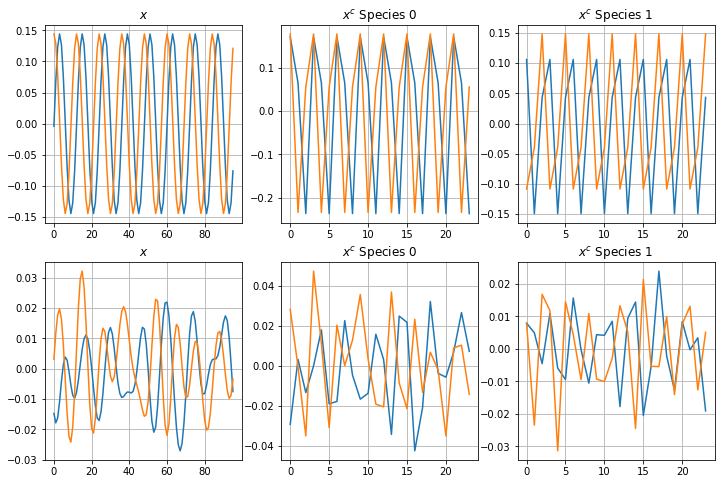

In [208]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
plot_test_vectors(x_ideal, xc_ideal, axs[0]);
plot_test_vectors(x_relaxed, xc_relaxed, axs[1]);

In [209]:
# # Apply R of relaxed vectors to the ideal vectors instead of constructing the ideal-TV coarsening.
xc_ideal = R.dot(x_ideal)

## Repetitive Rotation Angle Optimization
Sample $s$ windows aggregate pairs $(i,i+1)$ (pairs of consecutive coarse values of different test vectors in different parts of the domain). Let the matrices at $i$ and $i+1$ be $X_{2 \times s}$ and $Y_{2 \times s}$, respectively (recall that "coarse values" here means a pair of two coarse variables per aggregate).

* Step 1: Find the optimal rotation angle $\theta$ that minimizes
$$ \theta = argmin_{\theta} f(\theta) $$
$$ f(\theta) := \frac12 \left\{ \|\cos(\theta) X_0 + \sin(\theta) X_1 - Y_0 \|_2^2 + \|-\sin(\theta) X_0 + \cos(\theta) X_1 - Y_1\|_2^2 \right\}, $$
where $Z_j$ is the $j$th row of $Z$, $Z=X,Y, j=0,1$.

The minimization function $f$ seems to have a unique minimum in $[0, 2 \pi)$.

* Step 2: round $\theta$ to the nearest gridpoint $2 \pi l/n$ value for $l \in Z$ (or the one with the minimum $f$ value of the two grid neighbors of $\theta$). Now the periodicity is satisfied.

In [210]:
f, tmin = hm.setup.alignment.optimal_rotation_angle(xc_ideal)
f_relaxed, tmin_relaxed = hm.setup.alignment.optimal_rotation_angle(xc_relaxed)

+1.913539 2.715197e-01 2.691680e-01 (  1.01)
+0.223028 2.032243e-03 1.622256e-03 (  1.25)


In [211]:
norm(a.dot(x_ideal), axis=0) / norm(x_ideal, axis=0)

array([0.   , 0.   , 0.064, 0.064, 0.073, 0.073])

In [212]:
norm(a.dot(x_relaxed), axis=0) / norm(x_relaxed, axis=0)

array([0.116, 0.108, 0.123, 0.099, 0.104, 0.114])

For the ideal TVs, I reproduced Karsten's result ($\theta = \frac{\pi}{6}$) and the alignment is perfect. For relaxed vectors there is almost no gain from alignment. Why?

Note: this is also the case if the $R$ used for *both* TV sets is based on relaxed vectors.

<!-- ## Effect on Neighbor Distances
We measure the $L_2$ differences between corresponding coarse variables in neighboring aggregates before and before and after alighment. -->

## Neighbor Pairs Alignment Angles
For each aggregate pair $(i,j=i+1)$, with test matrices $X$ and $Y$ of size $2 \times s$, respectively, where $s$ is the number of test vectors, define a separate optimal neighbor rotation angle $\theta_{i,j}$ that minimizes

$$ \theta_{i,j} = argmin_{\theta} f(\theta), f(\theta) := \frac12 \left\{ \|\cos(\theta) X_0 + \sin(\theta) X_1 - Y_0 \|_2^2 + \|-\sin(\theta) X_0 + \cos(\theta) X_1 - Y_1\|_2^2 \right\}. $$

Here $Z_j$ is the $j$th row of $Z$, $Z=X,Y, j=0,1$.

### Ideal Vectors

<!-- The differences are reduced by a factor of $1.3-3$. Not as dramatic as for ideal test vectors, but already significant. -->

In [213]:
hm.setup.alignment.calculate_local_rotation_angles(n, aggregate_size, num_components, xc_ideal);

INFO     Agg t/pi      f0           fmin         factor   Dist Before   Dist After   
INFO     0   +0.679517 7.321140e-01 4.978880e-02 ( 14.70) [0.704 0.486] [0.181 0.131]
INFO     2   +0.684155 7.455181e-01 5.127215e-02 ( 14.54) [0.722 0.474] [0.184 0.132]
INFO     4   +0.686770 7.532766e-01 5.216699e-02 ( 14.44) [0.737 0.459] [0.187 0.131]
INFO     6   +0.682321 7.395147e-01 5.001928e-02 ( 14.78) [0.72  0.471] [0.181 0.131]
INFO     8   +0.677451 7.272364e-01 5.012083e-02 ( 14.51) [0.699 0.489] [0.18  0.133]
INFO     10  +0.685691 7.494380e-01 5.117135e-02 ( 14.65) [0.725 0.473] [0.185 0.13 ]
INFO     12  +0.687288 7.543334e-01 5.185018e-02 ( 14.55) [0.739 0.456] [0.186 0.132]
INFO     14  +0.679738 7.335111e-01 5.062454e-02 ( 14.49) [0.713 0.475] [0.182 0.132]
INFO     16  +0.680330 7.338630e-01 4.947209e-02 ( 14.83) [0.705 0.486] [0.18 0.13]
INFO     18  +0.684540 7.469327e-01 5.168103e-02 ( 14.45) [0.724 0.472] [0.185 0.132]
INFO     20  +0.686381 7.517928e-01 5.170945e-02 ( 14.54

### Relaxed Vectors

In [214]:
hm.setup.alignment.calculate_local_rotation_angles(n, aggregate_size, num_components, xc_relaxed);

INFO     Agg t/pi      f0           fmin         factor   Dist Before   Dist After   
INFO     0   +0.514380 5.102605e-03 1.805514e-03 (  2.83) [0.053 0.048] [0.034 0.026]
INFO     2   +0.682056 9.710162e-03 1.090170e-03 (  8.91) [0.083 0.053] [0.032 0.007]
INFO     4   +0.682391 1.373808e-02 1.131998e-03 ( 12.14) [0.106 0.049] [0.03  0.016]
INFO     6   +0.600063 1.108079e-02 1.232619e-03 (  8.99) [0.079 0.07 ] [0.022 0.027]
INFO     8   +0.688855 1.146613e-02 9.971643e-04 ( 11.50) [0.089 0.06 ] [0.026 0.018]
INFO     10  +0.635584 8.586992e-03 1.901804e-03 (  4.52) [0.085 0.038] [0.035 0.025]
INFO     12  +0.530659 6.202989e-03 2.200112e-03 (  2.82) [0.063 0.047] [0.037 0.029]
INFO     14  +0.637975 6.781408e-03 1.195645e-03 (  5.67) [0.065 0.05 ] [0.028 0.02 ]
INFO     16  +0.587422 6.612032e-03 1.503811e-03 (  4.40) [0.065 0.049] [0.032 0.023]
INFO     18  +0.578664 5.760790e-03 2.459873e-03 (  2.34) [0.072 0.025] [0.036 0.035]
INFO     20  +0.434939 3.921979e-03 1.422486e-03 (  2.

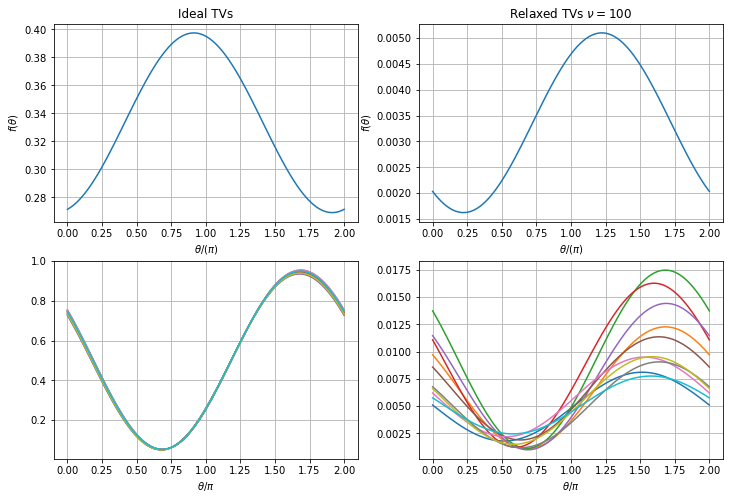

In [215]:
t = np.linspace(0, 2 * np.pi, 100)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

ax = axs[0, 0]
ax.plot(t / (np.pi), np.array([f(theta) for theta in t]))
ax.grid(True);
ax.set_xlabel(r"$\theta / (\pi)$")
ax.set_ylabel(r"$f(\theta)$");
ax.set_title("Ideal TVs")

ax = axs[0, 1]
ax.plot(t / (np.pi), np.array([f_relaxed(theta) for theta in t]))
ax.grid(True);
ax.set_xlabel(r"$\theta / (\pi)$")
ax.set_ylabel(r"$f(\theta)$");
ax.set_title(r"Relaxed TVs $\nu = {}$".format(num_sweeps));

hm.setup.alignment.plot_min_functions(n, aggregate_size, num_components, xc_ideal, axs[1, 0])
hm.setup.alignment.plot_min_functions(n, aggregate_size, num_components, xc_relaxed, axs[1, 1])

## Local Repetitive Angle Optimization
In a local domain of $m$ aggregates, let $X&i$ be the pair of coarse values at aggregate $i$.

* Step 1: Find the optimal rotation angle $\theta$ that minimizes
$$ \theta = argmin_{\theta} f(\theta) $$
$$ f(\theta) := \frac12 \sum_{i=0}^{m-1} \left\{ \|\cos(\theta) X^i_0 + \sin(\theta) X^i_1 - X^{i+1}_0 \|_2^2 + \|-\sin(\theta) X^i_0 + \cos(\theta) X^i_1 - X^{i+1}_1\|_2^2 \right\}, $$
where $Z_j$ is the $j$th row of $Z$, $Z=X,Y, j=0,1$.

The minimization function $f$ seems to have a unique minimum in $[0, 2 \pi)$.

* Step 2: round $\theta$ to the nearest gridpoint $2 \pi l/n$ value for $l \in Z$ (or the one with the minimum $f$ value of the two grid neighbors of $\theta$). Now the periodicity is satisfied.

In [221]:
hm.setup.alignment.calculate_local_repetitive_rotation_angle(4 * aggregate_size, num_components, xc_ideal);

INFO     Agg t/pi      f0           fmin         factor   Dist Before   Dist After   
INFO     0   +0.685265 7.32e-01 4.99e-02 ( 14.68) [0.704 0.486] [0.184 0.126] +0.679517 4.98e-02 ( 14.70) [0.704 0.486] [0.184 0.126]
INFO     2   +0.685265 7.46e-01 5.13e-02 ( 14.54) [0.722 0.474] [0.185 0.131] +0.684155 5.13e-02 ( 14.54) [0.722 0.474] [0.185 0.131]
INFO     4   +0.685265 7.53e-01 5.22e-02 ( 14.44) [0.737 0.459] [0.186 0.133] +0.686770 5.22e-02 ( 14.44) [0.737 0.459] [0.186 0.133]
INFO     6   +0.685265 7.40e-01 5.00e-02 ( 14.78) [0.72  0.471] [0.183 0.128] +0.682321 5.00e-02 ( 14.78) [0.72  0.471] [0.183 0.128]
INFO     8   +0.685265 7.27e-01 5.03e-02 ( 14.47) [0.699 0.489] [0.186 0.126] +0.677451 5.01e-02 ( 14.51) [0.699 0.489] [0.186 0.126]
INFO     10  +0.685265 7.49e-01 5.12e-02 ( 14.65) [0.725 0.473] [0.185 0.13 ] +0.685691 5.12e-02 ( 14.65) [0.725 0.473] [0.185 0.13 ]
INFO     12  +0.685265 7.54e-01 5.19e-02 ( 14.55) [0.739 0.456] [0.184 0.134] +0.687288 5.19e-02 ( 14.55) [0.7

In [222]:
hm.setup.alignment.calculate_local_repetitive_rotation_angle(4 * aggregate_size, num_components, xc_relaxed);

INFO     Agg t/pi      f0           fmin         factor   Dist Before   Dist After   
INFO     0   +0.634587 5.10e-03 2.03e-03 (  2.52) [0.053 0.048] [0.04  0.021] +0.514380 1.81e-03 (  2.83) [0.053 0.048] [0.04  0.021]
INFO     2   +0.634587 9.71e-03 1.15e-03 (  8.43) [0.083 0.053] [0.032 0.012] +0.682056 1.09e-03 (  8.91) [0.083 0.053] [0.032 0.012]
INFO     4   +0.634587 1.37e-02 1.22e-03 ( 11.22) [0.106 0.049] [0.027 0.022] +0.682391 1.13e-03 ( 12.14) [0.106 0.049] [0.027 0.022]
INFO     6   +0.634587 1.11e-02 1.28e-03 (  8.68) [0.079 0.07 ] [0.026 0.024] +0.600063 1.23e-03 (  8.99) [0.079 0.07 ] [0.026 0.024]
INFO     8   +0.634587 1.15e-02 1.09e-03 ( 10.48) [0.089 0.06 ] [0.022 0.025] +0.688855 9.97e-04 ( 11.50) [0.089 0.06 ] [0.022 0.025]
INFO     10  +0.634587 8.59e-03 1.90e-03 (  4.52) [0.085 0.038] [0.035 0.026] +0.635584 1.90e-03 (  4.52) [0.085 0.038] [0.035 0.026]
INFO     12  +0.634587 6.20e-03 2.39e-03 (  2.59) [0.063 0.047] [0.043 0.023] +0.530659 2.20e-03 (  2.82) [0.0